<a href="https://colab.research.google.com/github/ThomasMiconi/MetaMetaLearning/blob/main/Simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# What GPU are we using?
!nvidia-smi

Tue Feb  8 23:54:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

The next code cell runs the actual experiment. We use the NAND task as a withheld test task, with 400 generations and batch (population) size 500. 

If you want, you may set the withheld test task to DMS (modify TESTTASK and TESTTASKNEG), and increase the number of generations to 1700 (modify NBGEN). You can also set batch size to 1000 (modify BS), though the impact of batch size should be moderate.

Be sure to watch the clock time per generation, which is indicated in the output.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import pdb

import scipy
from scipy import ndimage
from scipy import linalg

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import time

import numpy as np
from numpy import fft 

from scipy import io as spio
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.set_printoptions(precision=5) 
np.set_printoptions(precision=5) 



# Specify the test task (and its logical negation, which is also withheld from the training set)
TESTTASK = 'nand'; TESTTASKNEG = 'and'
# TESTTASK = 'dms'; TESTTASKNEG = 'dnms'



LR =  .3 * 1e-2  # Adam LR. 

NBGEN = 400 #  1700 # 500      # Number of generations per run


N = 70  # Number of neurons in the RNN.



BS = 500 # 1000         # Batch size, i.e. population size for the evolutionary algorithm. 
assert BS % 2 == 0      # Should be even because of antithetic sampling.

# Same parameters as GR Yang:
TAU =  100  # Neuron membrane constant, in ms
DT = 20     # Duration of a timestep, in ms


# All the following times are in *timesteps*, not ms
T =  50      # Number of *timesteps* per trial
STIMTIME = 20       # Duration of stimulus input, total, *in timesteps* (not ms)
REWARDTIME = 10     # Duration of reward signal period
RESPONSETIME = 10   # Duration of responze period  
STARTRESPONSETIME = 25  # Timestep  at which response period starts
ENDRESPONSETIME = STARTRESPONSETIME + RESPONSETIME
STARTREWARDTIME = 36    # Timsestep at which reward is deliverd and reward signal starts
ENDREWARDTIME = STARTREWARDTIME + REWARDTIME
assert ENDREWARDTIME < T


JINIT = 1.5 #   Scale constant of initial network weights. See Section 2.7 in the MML paper.
TAU_ET = 1000.0    # Time constant of the eligibility trace (in ms)
PROBAMODUL = .1 #       Probability of receiving a random perturbation, for each neuron, at each timestep.
ALPHAMODUL =  .5 #      Scale of the random perturbations
ETA = .03 #             Learning rate for lifetime plasticity
MULOSSTRACE = .9    #   Time constant for the trace of previous losses that serves as a baseline for neuromodulation
MAXDW = 1e-2 #          Maximum delta-weight perimissible for lifetime plasticity (remember that plasticity is only applied once per trial, at reward delivery time)
INITALPHA = .5 #        Initial alpha (plasticity parameter) value


# The name of all the tasks
alltasks = ['01', 'anti01', '10', 'anti10', 'watchstim1', 'watchstim2' ,'dms',  'antiwatchstim2', 'antiwatchstim1', 'or', 'and', 'nor', 'nand', 'dnms']



NBSTIMNEURONS = 2   # 2 Stimulus neurons. Stimuli are binary, so both neurons receive opposite-valued inputs (or 0)
NBREWARDNEURONS = 2 # 2 binary-reward signal ("correct/incorrect for this trial") neurons. A binary value is represented with 2 inputs, as it is for stimulus neurons.
NBBIASNEURONS = 1   # Bias neurons. Activations clamped to BIASVALUE.
NBINPUTNEURONS = NBSTIMNEURONS + NBREWARDNEURONS  + NBBIASNEURONS    # The first NBINPUTS neurons in the network are neurons (includes the bias, noise and reward inputs)
NBRESPNEURONS = 2  # Response neurons for 0 and 1.
NBOUTPUTNEURONS = NBRESPNEURONS    # The last NBOUTPUTNEURONS neurons in the network are output neurons. There could be other non-response output neurons, but they're not used in this version of the code so NbOutputN = NbRespN
NBRESPSIGNALNEURONS = NBRESPNEURONS     # Neurons that receive the response-given signal ("what response did I just give?")
STIMNEURONS = np.arange(NBSTIMNEURONS)
INPUTNEURONS = np.arange(NBINPUTNEURONS)
OUTPUTNEURONS = np.arange(N-NBOUTPUTNEURONS, N)
RESPNEURONS = np.arange(N-NBOUTPUTNEURONS, N-NBOUTPUTNEURONS + NBRESPNEURONS)
REWARDNEURONS = np.arange(NBSTIMNEURONS, NBSTIMNEURONS+NBREWARDNEURONS) # The neurons receiving (and broadcasting) the "correct/incorrect for this trial" signal are the ones just after the stimulus inputs.
BIASNEURONS = np.arange(NBSTIMNEURONS+NBREWARDNEURONS, NBSTIMNEURONS+NBREWARDNEURONS+NBBIASNEURONS)
FIRSTRESPSIGNALNEURON = NBSTIMNEURONS+NBREWARDNEURONS+NBBIASNEURONS   # The first neuron that receives the response-given signal. We'll need this later
assert FIRSTRESPSIGNALNEURON == NBINPUTNEURONS
RESPSIGNALNEURONS = np.arange(FIRSTRESPSIGNALNEURON, FIRSTRESPSIGNALNEURON +NBRESPSIGNALNEURONS)


BIASVALUE = 1.0



NBTASKSPERGEN = 2 #  2 task blocks per generation


NBTRIALSLOSS = 100              # Evolutionary loss is evaluated over the last 100 trials of each block
NBTRIALS =  300 + NBTRIALSLOSS  # Total number of trials per block


WDECAY =  3e-4 # Evolutionary weight decay parameter (for the Adam optimizer)
MUTATIONSIZE = .01 #  Std dev of the Gaussian mutations of the evolutionary algorithm

REWARDSIZE = 3.0 # Size of the binary-reward signal (correct/incorrect)
STIMSIZE = 3.0 # Size of the stimulus input
RESPSIGNALSIZE = 3.0 # Size of the response-given signal


totalnbtasks = 0
ticstart = time.time()


with torch.no_grad():  # We don't need PyTorch to keep track of gradients, since we're computing the gradient outselves (through evolution).
 
    PRINTING = True # if numgen == 0 or np.random.rand() < .05 else False

    # Initialize innate weights values
    w =  torch.randn(N,N)  * JINIT / np.sqrt(N) 
    w = w.to(device)
    
    # Initialize alpha values - the plasticity parameters (capital-pi in the paper)
    alpha = INITALPHA * torch.ones_like(w).to(device)

    # We zero out input weights to input neurons, though it probably doesn't have any effect.
    w.data[:NBINPUTNEURONS, :] = 0   # Each *row* of w contains the weights to a single neuron.
    winit = w.clone()

    # We will be using the Adam optimizer to apply our (hand-computed) evolutionary gradients
    optimizer = optim.Adam([w, alpha], lr=LR, weight_decay=WDECAY)  # Default betas=(0.9, 0.999)

    # Evolosses are real-valued losses used for evolution. Binarylosses are binary 'correct/wrong' signals, also used for logging.
    evolosses = []
    responses0 = []
    binarylosses = []
    wgradnorms = []
    mytaskprev = mytaskprevprev = mytaskprevprevprev = -1
    

    # Ready to start the evolutionary loop, iterating over generations (i.e. lifetimes). 

    for numgen in range(NBGEN):

        # Every 10th generation is for testing on the withheld task (with no weight change)
        TESTING = False
        if numgen == 0 or numgen == NBGEN-1 or numgen % 10 == 0:
            TESTING = True
            if PRINTING:
                print("TESTING")


        tic = time.time()   
        responses0thisgen = []
    
        # Generating the population of mutated individuals:

        # First, batch the weights.
        bw = torch.dstack(BS*[w]).movedim(2,0).to(device)     # batched weights
        balpha = torch.dstack(BS*[alpha]).movedim(2,0).to(device)     # batched alphas
        # Generate the mutations, for both w and alpha
        # NOTE: batch element 0 (and BS/2, its antithetic pair) are NOT mutated, represent the curent unmutated candidate genotype.
        mutations_wandalpha = []
        for  n, x in enumerate( (bw, balpha) ):
            mutations = torch.randn_like(x, requires_grad=False).to(device) *  MUTATIONSIZE
            mutations[0,:,:] = 0  # 1st item in batch = current candidate
            mutations[BS//2:, :, :] = -mutations[:BS//2, :, :]    # Antithetic sampling for mutations ! Really helps.
            if TESTING:
                mutations *= 0.0  # Not strictly necessary (no weight change is applied) - results in batch score variance being caused only by randomness in trial order
            x += mutations  
            mutations_wandalpha.append(mutations)


        
        bw.data[:, :NBINPUTNEURONS, :] = 0  # Input neurons receive 0 connections. Probably not necessary.
        bworig = bw.clone()                 # Storing the weights for comparison purposes at the gradient step (below).

        lifelosses = torch.zeros(BS, requires_grad=False).to(device)
        lifemselosses = torch.zeros(BS, requires_grad=False).to(device)
        # lifemselossesaux = torch.zeros(BS, requires_grad=False).to(device)
        lifeblosses = torch.zeros(BS, requires_grad=False).to(device)
            
        allresps=[]


        # Lifetime loop, iterates over task-blocks:
        for numtask in range(NBTASKSPERGEN):
            totalnbtasks += 1

            # bpw = batched plastic weights
            bpw = torch.zeros_like(bw).to(device)  # For now, plastic weights are initialized to 0 at the beginning of each task.

            # Initialize neural states
            bstates = .1 * torch.ones(BS, N).to(device)  # bstates (batched states) contains the neural activations (before nonlinearity). Dimensionality appropriate for batched matrix multiplication. 
            bstates[:, INPUTNEURONS] = 0
            bresps = 1.0 * bstates  # bresps is the actual neural responses, after nonlinearity, and also serve as the input for the next step.
            bresps[:, BIASNEURONS] = BIASVALUE

            meanlosstrace = torch.zeros(BS, 2 * 2).to(device)
            bls = []    # Will store binary losses of all batch elements, for each trial of this task
            bl0s = []   # Same but only for batch element 0 (i.e. the unmutated candidate genome)
            ml0s = []   # MSE loss (the one used for evolution) for element 0 (unmutated candidate), of all trials for this task


            # Choose the task ! If not testing, makes sure it's different from recently chosen tasks.

            if TESTING: 
                mytask = TESTTASK 
                mytasknum = alltasks.index(mytask)
            else:
                while True:
                    mytasknum = np.random.randint(len(alltasks))

                    mytask = alltasks[mytasknum]

                    if ( (mytask!= TESTTASK)  
                        and (mytask != TESTTASKNEG)  # We withhold both the test task and its logical negation
                        and     (mytask != mytaskprev) 
                            and (mytask != mytaskprevprev) 
                    ):

                        break

                mytaskprevprev = mytaskprev; mytaskprev= mytask
            
            # Cumulative MSE and binary losses for this task, over the last NBLOSSTRIALS of the block:
            taskmselosses = torch.zeros_like(lifemselosses).to(device)
            taskblosses = torch.zeros_like(lifemselosses).to(device)

            if PRINTING:
                print("task", mytask)
            
            # OK, ready to start the task.

            # Generate the task data (inputs and targets) for all trials:
            # taskdata = generateInputsAndTargetsForTask(mytask=mytask)

            eligtraces =   torch.zeros_like(bw, requires_grad=False).to(device)  # Initialize the eligibility traces at the start of each block/task.

            # Task loop, iterating over trials
            # You do NOT erase memory (neural activations or plastic weights) between successive trials ! 
            for numtrial in range(NBTRIALS):
                
                # Initializations
                mselossesthistrial = torch.zeros(BS, requires_grad=False).to(device)     # MSE losses for this trial
                totalouts = torch.zeros(BS, NBOUTPUTNEURONS, requires_grad=False).to(device)     # Will accumulate the total outputs of each network over the trial, so we can compute the network's response for this trial.  

                # Generate the inputs and targets for this trial:

                # Pick stimulus 1 and stimulus 2 for this trial (and for each batch member):
                stims1 = (torch.rand(BS, 1) > .5).float()
                stims2 = (torch.rand(BS, 1) > .5).float()
                
                # Actual temporal inputs:
                inpts = np.zeros((BS, NBSTIMNEURONS, STIMTIME)) 
                StimDur = STIMTIME; StartStim = 0
                # The two stimuli are presented in succession, with both input neurons locked in opposite values to each other:
                inpts[:, 0, StartStim:StartStim+StimDur//2 - 2] = 2.0 * stims1 - 1.0
                inpts[:, 0, StartStim+StimDur//2:StartStim+StimDur - 2] = 2.0 * stims2 - 1.0
                inpts[:, 1, StartStim:StartStim+StimDur] = -inpts[:, 0, StartStim:StartStim+StimDur] 

                inputs = torch.from_numpy(inpts).float().to(device)

            
                # Now we compute the targets, that is, the expected values of the output neurons, depending on inputs and tasks
                tgts = np.zeros((BS, NBRESPNEURONS, RESPONSETIME))

                # First we generate the expected output for the non-null response neuron, based on inputs and task:
                if mytask == 'watchstim1':
                    tgts[:, 1, :] = stims1
                elif mytask == 'watchstim2':
                    tgts[:, 1, :] = stims2
                elif mytask == 'antiwatchstim1':
                    tgts[:, 1, :] = 1.0 - stims1
                elif mytask == 'antiwatchstim2':
                    tgts[:, 1, :] = 1.0 - stims2
                elif mytask == 'and':
                    tgts[:, 1, :] = (stims1 * stims2)
                elif mytask == 'nand':
                    tgts[:, 1, :] = 1.0 - (stims1 * stims2)
                elif mytask == 'or':
                    tgts[:, 1, :] = np.clip(stims1 + stims2, 0.0, 1.0)
                elif mytask == 'nor':
                    tgts[:, 1, :] = 1.0 - np.clip(stims1 + stims2, 0.0, 1.0)
                elif mytask == '10':
                    tgts[:, 1, :] = stims1 * (1.0 - stims2)
                elif mytask == 'anti10':
                    tgts[:, 1, :] = stims1 * (1.0 - stims2)
                elif mytask == '01':
                    tgts[:, 1, :] = (1.0 - stims1) * stims2
                elif mytask == 'anti01':
                    tgts[:, 1, :] = 1.0 - (1.0 - stims1) * stims2
                elif mytask == 'dms':
                    tgts[:, 1, :] = (stims1  == stims2)
                elif mytask == 'dnms':
                    tgts[:, 1, :] = (stims1  != stims2)
                else:
                    raise ValueError("Task not in list of allowed tasks! Task is"+str(mytask))

                assert np.all(np.logical_or(tgts == 0.0 , tgts == 1.0))

                # The null-response neuron's expected output is just the opposite of the non-null response neuron output (response is either 0 or 1).
                tgts[:, 0, :] = 1.0 - tgts[:, 1, :]

                targets = torch.from_numpy(tgts).float().to(device)     

                # In practice, we clip targets to 0.1/0.9 instead of actually 0.0/1.0. This may or may not help.
                targets.clip_(min=0.1, max=0.9)


                # Run the network. Trial loop, iterating over timesteps
                for numstep in range(T):          

                    # Update neural activations, using previous-step bresps (actual neural outputs) as input:
                    bstates += (DT / TAU) * (-bstates +  torch.bmm((bw + balpha * bpw), bresps[:, :, None])[:,:,0] )  


                    # Applying the random perturbations on neural activations, a.k.a. "modulations", both for noise and for the lifetime plasticity algorithm (node-perturbation)
                    # Ans also updating the eligibility trace appropriately
                    if numstep > 1 : 
                        modulindices =  (torch.rand(1, N) < PROBAMODUL).int()   # Which neurons get perturbed?
                        modulations = (ALPHAMODUL * modulindices * (2 * torch.rand(1, N) - 1.0)).to(device)  # Note the dimensions: the same noise vector is applied to all elements in the batch (to save time!)
                        
                        bstates += modulations
                        
                        # Node-perturbation: Hebbian eligibility trace = product between inputs (bresps from previous time step) and *perturbations* in outputs. dH = X * deltaY 
                        # We do this with a (batched) outer product between the (column) vector of modulations (1 per neuron) and the (row) vector of inputs
                        # Note that here, since we have an RNN, the input is bresps - the network's responses from the previous time step
                        if torch.sum(modulindices) > 0:
                            eligtraces += torch.bmm( modulations.expand(BS, -1)[:, :, None],  bresps[:, None, :] ) 

                    # Eligibility traces, unlike actual plastic weights, are decaying
                    eligtraces -=  (DT / TAU_ET) * eligtraces


                    # We can now compute the actual neural responses for this time step, applying the appropriate nonlinearity to each neuron
                    bresps = bstates.clone() # F.leaky_relu(bstates)
                    # The following assumes that output neurons are the last neurons of the network !                        
                    bresps[:,N-NBOUTPUTNEURONS:].sigmoid_()     # The output neurons are sigmoids, all others are tanh. An arbitrary design choice.
                    bresps[:,:N-NBOUTPUTNEURONS].tanh_()
                    

                    # Are we in the input presentation period? Then apply the inputs.
                    # Inputs are clamping, fixing the response of the input neurons.
                    if numstep < STIMTIME:
                        bresps[:, STIMNEURONS] = STIMSIZE * inputs[:, :, numstep]        
                    else:
                        bresps[:, STIMNEURONS] = 0

                    # Bias input is always-on, always clamping.
                    bresps[:, BIASNEURONS] = BIASVALUE


                    # Are we in the response period? Then collect network response.
                    if numstep >= STARTRESPONSETIME and numstep < ENDRESPONSETIME:

                        assert numstep < STARTREWARDTIME
                        # Accumulate the total activation of each output neuron, so that we can compute the network's actual response at the end of response period:
                        totalouts +=  bresps[:, OUTPUTNEURONS] 
                        # Accumulate the MSE error between actual and expected outputs:
                        mselossesthistrial += torch.sum( (bresps[:, RESPNEURONS] - targets[:, :, numstep - STARTRESPONSETIME]) ** 2, axis=1 ) / RESPONSETIME

                    else:
                        bresps[:, OUTPUTNEURONS] = 0.0


                    # Is the response period finished, or equivalently, are we at the first step of the reward / feedback period?
                    # If so, compute the network's response and apply plasticity (i.e. deliver the neuromodulation).
                    if numstep == STARTREWARDTIME:
                        # The network's response for this trial (0 or 1) is the index of the output neuron that had the highest cumulative output over the response period
                        totalresps = totalouts[:, :NBRESPNEURONS]   # Assumes that the response neurons are the first among output neurons !
                        responses = torch.argmax(totalresps, dim=1)  # responses is a 1D, integer-valued array of size BS. totalresps is a 2D real-vlued array of size BS, NBRESPS+1                           
                        
                        # blosses (binary losses) is a 1/-1 "correct/wrong" signal for each batch element for this trial.
                        blosses = 2.0 * (responses == torch.argmax(targets[:, :, 0], dim=1)).float() - 1.0    
                        responses0thisgen.append(float(responses[0]))

                        # We also want the 1-hot version of the response for each neuron. This will be used as the response signal below.
                        if numtrial > 0:
                            responses1hot_prev = responses1hot.clone()
                        responses1hot = F.one_hot(responses, 2)

                        # Now we apply lifetime plasticity, with node-perturbation, based on eligibility trace and suitably baselined reward/loss

                        # We compute separate baseline (running average) losses for different types of trials, as defined by their inputs (as in Miconi, eLife 2017). 
                        # So we need to find out the trial type for each element in batch.
                        input1 = inputs[:, 0, 0]; input2 = inputs[:, 1, 0]  # This assumes that inputs are constant and start from timestep 0 !
                        trialtypes = (input1>0).long() * 2 + (input2>0).long()

                        # Compute and apply the plasticity, based on accumulated eligibility traces and reward                          
                        if numtrial > 30:  # Lifetime plasticity is only applied after a few burn-in trials.
                            # eligtraces: BS x N x N.   mselossesthhistrial:  BS.    meanlosstrace: BS x (N.N).    trialtypes: BS
                            # dw should have shape BS x N x N, i.e. one for each connection and batch element. Do not sum over batch dimension! The batch is purely evolutionary !


                            dw =   (ETA * eligtraces  * (  meanlosstrace[np.arange(BS), trialtypes] * (mselossesthistrial - meanlosstrace[np.arange(BS), trialtypes]) )[:, None, None]).clamp(-MAXDW, MAXDW)
                            # dw =   (ETA * eligtraces  * (  meanlosstrace[np.arange(BS), trialtypes] * (mselossesthistrial ) )[:, None, None]).clamp(-MAXDW, MAXDW)  # Without baselining. Works less well!


                            bpw -= dw

                            if PRINTING and np.random.rand() < .02:
                                print(numtrial, "{:.4f}".format(float(torch.mean(mselossesthistrial))), "{:.4f}".format(float(torch.norm(bw+bpw))), 
                                                                    "{:.4f}".format(float(torch.norm(dw))), "{:.4f}".format(float(torch.norm(bpw))))
                        # Updating the baseline - running average of losses, for each batch element, for the trial type just seen
                        meanlosstrace[torch.arange(BS).long(), trialtypes] *= MULOSSTRACE
                        meanlosstrace[torch.arange(BS).long(), trialtypes] +=  (1.0 - MULOSSTRACE) * mselossesthistrial



                    # Are we in the reward signal period?
                    # Note: the actual neuromodulatory reward signal (which influences plasticity) is applied just once per trial, above. Here we provide a binary "correct/ incorrect" signal to the network, 
                    # i.e. "was my response right or wrong for this trial?" 
                    # We also provide a signal indicating which response it gave in this trial (in theory it should be able to calculate it itself if needed, but this may help).
                    if numstep >= STARTREWARDTIME and numstep < ENDREWARDTIME: # Note that by this time, the loss has been computed and is fixed
                        
                        # We provide a binary, "correct/incorrect" signal to the network
                        bresps[:,REWARDNEURONS[0]] = REWARDSIZE * blosses[:]         # Reward input is also clamping
                        bresps[:,REWARDNEURONS[1]] = -REWARDSIZE * blosses[:]         # Reward input is also clamping

                        bresps[:,REWARDNEURONS].clip_(min=0)

                        # We provide the network with a signal indicating the actual response it chose for this trial.  
                        bresps[:, RESPSIGNALNEURONS] = responses1hot.float() * RESPSIGNALSIZE


                        
                    else:
                        bresps[:,REWARDNEURONS] = 0
                        bresps[:, RESPSIGNALNEURONS] = 0


                
                # Now all steps done for this trial:
            
                if PRINTING:
                    if np.random.rand() < .1: 
                        print("|", int(responses[0]), int(blosses[0]), end=' ')
                
                ml0s.append(float(mselossesthistrial[0]))
                bl0s.append(float(blosses[0]))
                bls.append(blosses.cpu().numpy())


                # If this trial is part of the last NBTRIALSLOSS, we accumulate its trial loss into the agent's total loss for this task.
                if numtrial >= NBTRIALS - NBTRIALSLOSS:     # Lifetime  losses are only estimated over the last few trials
                    taskmselosses += 2 * mselossesthistrial / NBTRIALSLOSS   # the 2* doesn't mean anything
                    taskblosses += blosses / NBTRIALSLOSS
            

            # Now all trials done for this task:
            if PRINTING:
                print("Med task mseloss:", "{:.4f}".format(float(torch.median(taskmselosses))))


                # print("")
            lifemselosses += taskmselosses / NBTASKSPERGEN 
            lifeblosses += taskblosses / NBTASKSPERGEN 
        
            if (TESTING or numgen == 0) and numtask == 0:
                # These files contain respectively the first and *latest* Testing block of the *current* run only. 
                FNAME = 'bl_1standLastBlock_gen0.txt' if numgen == 0 else 'bl_1standLastBlock_lastgen.txt'
                # np.savetxt(FNAME, np.array(bl0s))
                np.savetxt(FNAME, np.vstack(bls))



        # After all tasks done for this lifetime / generation:

        lifelosses = lifemselosses 

        binarylosses.append(float(lifeblosses[0]))
        evolosses.append(float(lifemselosses[0]))

        np.savetxt('blosses_onerun.txt', np.array(binarylosses))
        np.savetxt('mselosses_onerun.txt', np.array(evolosses))
        

        # Now we're ready to perform evolution (by computing gradients by hand, and then applying the optimizer with these gradients)
        optimizer.zero_grad()

        # Gradient is just loss x mutation (remember we use antithetic sampling)
        gradient = torch.sum(mutations_wandalpha[0] * lifelosses[:, None, None], axis=0) # / BS
        wgradnorm = float(torch.norm(gradient))
        wgradnorms.append(wgradnorm)
        if PRINTING:
            print("norm w:", "{:.4f}".format(float(torch.norm(w))), "norm gradient:", "{:.4f}".format(wgradnorm), 
                    "norm a:", "{:.4f}".format(float(torch.norm(alpha))), "mean a:",  "{:.4f}".format(float(torch.mean(alpha))))


        w.grad = gradient
        wprev = w.clone()

        gradientalpha = torch.sum(mutations_wandalpha[1] * lifelosses[:, None, None], axis=0) # / BS
        alpha.grad = gradientalpha
        alphaprev = alpha.clone()

        if numgen > 0 and not TESTING:
            optimizer.step()

        
        wdiff = w - wprev
        adiff = alpha - alphaprev
        if PRINTING:
            print("Norm w-wprev:", "{:.4f}".format(float(torch.norm(wdiff))), "Max abs w-wprev:", "{:.4f}".format(float(torch.max(torch.abs(wdiff)))), 
                "Norm a-aprev:", "{:.4f}".format(float(torch.norm(adiff))), "Max abs a-aprev:", "{:.4f}".format(float(torch.max(torch.abs(adiff))))  )

    

        if PRINTING:
            print("Med/min/max/Half-Nth/0th loss in batch:", float(torch.median(lifelosses)), float(torch.min(lifelosses)), float(torch.max(lifelosses)),
                                    float(lifelosses[BS//2]), float(lifelosses[0]))
            print("Gen", numgen, "done in", time.time()-tic)
    





print("Time taken:", time.time()-ticstart)

First, we show batch performance in the last block of the last generation (which should be a test task block). We plot the batch success rate (i.e. the mean binary loss over the batch), as a function of time (in trials), over the last test-task block. 

If the network has evolved the ability to acquire the (withheld) test task, we should see an increase.


(335, 500)


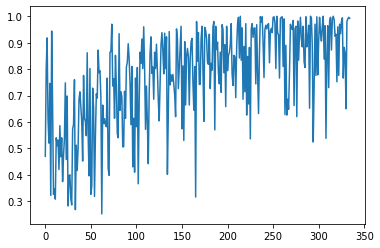

In [3]:
import matplotlib.pyplot as plt; import numpy as np

z = .5 + .5 * np.vstack(bls)
print(z.shape)
plt.plot(np.mean(z, axis=1))

Training trajectory: we plot the performance (mean success rate over the last 100 trials of both blocks of each generation) as a function of time (in generations). Note that only the performance of batch element 0 (i.e. the unmutated genotype for the current generation) is shown.

Performance is shown separately for training tasks (blue) and test task (red). Because there is only one run, no spread will be shown. (Run the experiment multiple times, concatenate the files and use the resulting file to see the medians and inter-quartile ranges).

(1, 290)


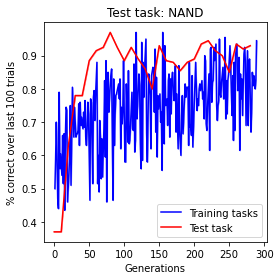

In [5]:
# % correct over last 100 trials of each generation (unmutated candidate genotype only), shown separately for the non-test tasks (blue) and test task (red)
# Median and IQR over all runs. 

bl = .5 + .5 * np.loadtxt('blosses_onerun.txt')
if(len(bl.shape)<2):   # If there is only a single run, add a singleton dimension
    bl = bl[None, :]
print(bl.shape)
ss = bl.shape[1]  # Number of generations

plt.figure(figsize=(4,4))

xr = np.arange(len(bl[0,:]))
plt.fill_between(xr[xr%10 != 0], np.quantile(bl, .25, axis=0).T[xr % 10 != 0], np.quantile(bl, .75, axis=0).T[xr % 10 != 0], color='b', alpha=.3)
plt.plot(xr[xr % 10 != 0], np.quantile(bl, .5, axis=0).T[xr % 10 != 0], 'b', label='Training tasks');
plt.fill_between(xr[::10], np.quantile(bl, .25, axis=0).T[0::10], np.quantile(bl, .75, axis=0).T[0::10], color='r', alpha=.3)
plt.plot(xr[::10], np.quantile(bl, .5, axis=0).T[0::10], 'r', label='Test task')


plt.xlabel('Generations')
plt.ylabel('% correct over last 100 trials')
plt.legend(loc='lower right')

plt.title('Test task: '+str(TESTTASK).upper())

plt.tight_layout()

plt.savefig('evoloss'+str(TESTTASK).upper()+'.png', dpi=300)


In [6]:
# This was code for showing the trajectories of multiple neurons over several trials, but we don't store them ('allresps') any more due to mempry constraints. 
# I still keep the code for possible future use.

if False:
    ar1 = torch.dstack(allresps) # Now allresps has dimensions batchsize x neurons x time

    # If the network is not chaotic enough and they all have the same weights, they will produce very similar final outputs independently of initial conditions - because eigenvectors !
    ar = ar1.cpu().numpy()
    print(ar.shape)
    ar[ar>1.5] = 1.5
    ar[ar<-1.5] = -1.5

    plt.figure(figsize=(20,20))
    z = plt.plot(ar[1,:20,-1000:].T)  # 20 first neurons of batch element 1
    z = plt.plot(ar[1,-1,-1000:].T, 'r--')  # Last (response) neuron of batch element 1
    z = plt.plot(ar[1,-2,-1000:].T, 'b--')  # Last (response) neuron of batch element 1
    plt.figure(figsize=(10,10))
    z = plt.plot(ar[0,:20,-1000:].T)  # 20 first neurons of batch element 0
    z = plt.plot(ar[0,-1,-1000:].T, 'r--')  # Last (response) neuron of batch element 0
    z = plt.plot(ar[0,-2,-1000:].T, 'b--')  # Last (response) neuron of batch element 0


We show the final evolved **w** matrix (that is, the evolved innate weights), as well as its column and row averages.


Std W: 0.17610234 Norm W 12.329204
Std w_init_like: 0.18113008445715229 norm: 12.67988664589771
-0.7309814 0.61439323 -0.0046788715
-0.6641202635343967 0.6716511467833278 -0.0009294276237743339


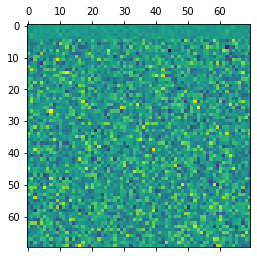

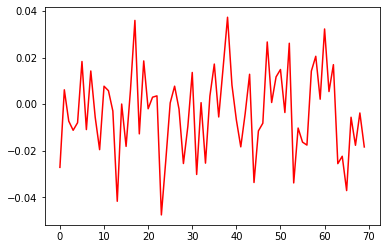

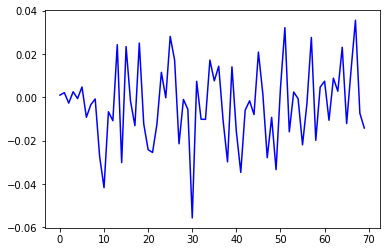

In [7]:
import matplotlib.pyplot as plt; import numpy as np

ww = w.cpu().numpy()
print("Std W:", np.std(ww), "Norm W", np.sqrt(np.sum(ww**2)))
zz = np.random.randn(N,N)  * JINIT / np.sqrt(N) 
print("Std w_init_like:", np.std(zz), "norm:", np.sqrt(np.sum(zz**2)))
print(np.min(ww), np.max(ww), np.median(ww))
print(np.min(zz), np.max(zz), np.median(zz))

plt.matshow(ww)
plt.figure()
plt.plot(np.mean(ww, axis=0), 'r')
plt.figure()
plt.plot(np.mean(ww, axis=1), 'b')

Same thing for the **alpha** matrix - that is, the evolved plasticity coefficients.

0.4875299
0.3010353 0.66642934 0.48841214


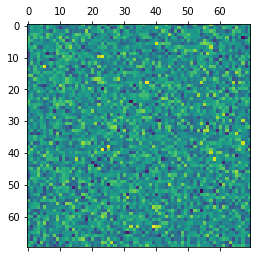

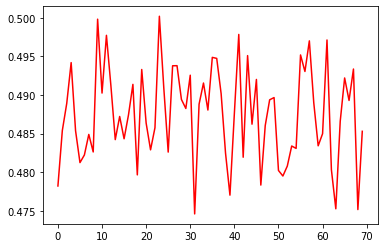

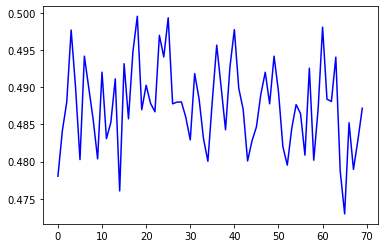

In [8]:
# Show the final evolved alpha matrix (plasticity parameters, capital-Pi in the MML paper)


aa = alpha.cpu().numpy()

print(np.mean(aa))
print(np.min(aa), np.max(aa), np.median(aa))
plt.matshow(aa)
plt.figure()
plt.plot(np.mean(aa, axis=0), 'r')
plt.figure()
plt.plot(np.mean(aa, axis=1), 'b')

We show the plastic weights, at the end of the last block of the whole run (which should be a test task block). We both show the average plastic weights over the whole batch, and the individual plastic weight matrices of two individuals.

Note that, because we do not use any mutation in test task generations, the genome of these two individuals should be identical, and any difference results from the different sequence of stimuli experienced.

(500, 70, 70)
0.13809678 0.005251596
0.7309814 0.07080955
-0.041757826 0.041757826 -8.738835e-06


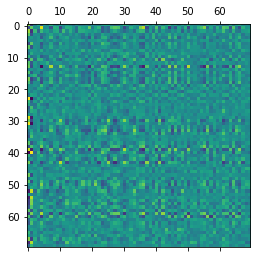

<Figure size 432x288 with 0 Axes>

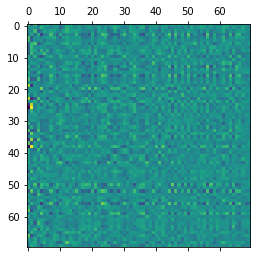

<Figure size 432x288 with 0 Axes>

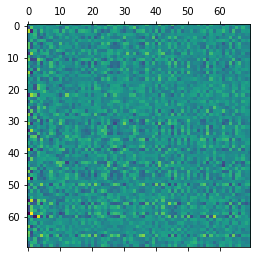

In [9]:
# Show the mean plastic weights over the whole batch., and for two elements in the batch (note that this is after the end of the last block)

pw = bpw.cpu().numpy()

print(pw.shape)
plt.matshow(np.mean(pw, axis=0))
print(np.mean(np.abs(w.cpu().numpy())), np.mean(np.abs(pw)))
print(np.max(np.abs(w.cpu().numpy())), np.max(np.abs(pw)))
print(np.min(pw[0,:,:]), np.max(pw[0,:,:]), np.median(pw[0,:,:]))
plt.figure()
plt.matshow(pw[0,:,:])
plt.figure()
plt.matshow(pw[1,:,:])


Saving the matrices of w, alpha, and final plastic weights of batch element 0.

In [10]:
ww = w.cpu().numpy()
pw0 = bpw[0,:,:].cpu().numpy()
aa = alpha.cpu().numpy()
np.savetxt('w.txt', ww)
np.savetxt('pw0.txt', pw0)
np.savetxt('alpha.txt', aa)